**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Text Data](#toc2_)    
  - 2.1. [Reddit](#toc2_1_)    
    - 2.1.1. [Scrape the data](#toc2_1_1_)    
    - 2.1.2. [Inspect the Data](#toc2_1_2_)    
    - 2.1.3. [Missing values](#toc2_1_3_)    
    - 2.1.4. [Invalid Data](#toc2_1_4_)    
    - 2.1.5. [Data Preparation](#toc2_1_5_)    
    - 2.1.6. [Data Exploration](#toc2_1_6_)    
    - 2.1.7. [Data Visualization](#toc2_1_7_)    
      - 2.1.7.1. [Text Length Analysis](#toc2_1_7_1_)    
      - 2.1.7.2. [Word Clouds](#toc2_1_7_2_)    
    - 2.1.8. [Missing Values](#toc2_1_8_)    
  - 2.2. [Twitter](#toc2_2_)    
  - 2.3. [News](#toc2_3_)    
- 3. [VADER Sentiment Scores](#toc3_)    
  - 3.1. [Twitter](#toc3_1_)    
  - 3.2. [Reddit](#toc3_2_)    
  - 3.3. [News](#toc3_3_)    
- 4. [Combine Data with Stock Prices](#toc4_)    
  - 4.1. [Load the data](#toc4_1_)    
  - 4.2. [Merge with Reddit data](#toc4_2_)    
  - 4.3. [Merge with Twitter data](#toc4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Setup](#toc0_)

.\venv\Scripts\activate

pip freeze > requirements.txt

In [13]:
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf
import praw
import prawcore.exceptions

import datetime
import datetime as dt
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

import os

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sohmt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sohmt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sohmt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. <a id='toc2_'></a>[Text Data](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Reddit](#toc0_)

Based on previous observations in Scrape_RedditPosts.ipynb, out of all methods, let us go forward with **Scraping from different Subreddits.**

### 2.1.1. <a id='toc2_1_1_'></a>[Scrape the data](#toc0_)

In [145]:
# Script to scrape Reddit posts related to all stocks from different subreddits

# Initialize the Reddit API client
reddit = praw.Reddit(
    client_id="2aV6_rxA1c44CoHtxY6e0A",
    client_secret="7rbu00bmyQOlnHCu-xjyTa-U5har-g",
    user_agent="Project Capstone"
)

# list of subreddits to search
subreddits_to_search = ['stocks', 'investing', 'wallstreetbets', 'finance', 'economy', 'stockmarket', 'business']

# list of search queries
search_queries = ['Apple Stocks OR AAPL', 'Google Stocks OR GOOG', 'Netflix Stocks OR NFLX', 'TESLA Stocks OR TSLA', 'Microsoft Stocks OR MSFT']

# Define the date range (January 1, 2015, to December 31, 2020) for consistency
start_date = datetime.date(2015, 1, 1)
end_date = datetime.date(2020, 12, 31)

# lists to store data
titles = []
authors = []
scores = []
urls = []
contents = []
post_dates = []
subreddit_names = []
query_names = []

# Iterate through each subreddit
for subreddit_name in subreddits_to_search:
    for search_query in search_queries:
        try:
            subreddit = reddit.subreddit(subreddit_name)
            posts = subreddit.search(search_query, limit=None)

            # Iterate through the search results and collect data
            for post in posts:
                post_date = pd.to_datetime(post.created_utc, unit='s').date()
                if start_date <= post_date <= end_date:
                    if post.selftext:  # Check if the post has text content
                        titles.append(post.title)
                        authors.append(post.author)
                        scores.append(post.score)
                        urls.append(post.url)
                        contents.append(post.selftext)
                        post_dates.append(pd.to_datetime(post.created_utc, unit='s'))
                        subreddit_names.append(subreddit_name)
                        query_names.append(search_query[-4:])

        # handle the exceptions
        except prawcore.exceptions.NotFound as e:
            print(f"Error in subreddit '{subreddit_to_search}': {e}")
        except prawcore.exceptions.Forbidden as e:
            print(f"Access forbidden in subreddit '{subreddit_to_search}': {e}")
        except praw.exceptions.APIException as e:
            print(f"API Error: {e}")
            # Wait for a while before retrying (e.g., 5 seconds)
            time.sleep(5)

# Create a DataFrame from the collected data
data = {
    'Stock': query_names,
    'Subreddit': subreddit_names,
    'Title': titles,
    'Author': authors,
    'Score': scores,
    'URL': urls,
    'Content': contents,
    'Date': post_dates,
}
df = pd.DataFrame(data)

# drop duplicate
df = df.drop_duplicates(subset='URL')

# Sort by date
df = df.sort_values(by='Date')

# Store as csv file
df.to_csv('Data\RedditPosts.csv')

In [14]:
df_reddit = pd.read_csv('Data/RedditPosts.csv')

### 2.1.2. <a id='toc2_1_2_'></a>[Inspect the Data](#toc0_)

In [15]:
df_reddit

,Unnamed: 0,Stock,Subreddit,Title,Author,Score,URL,Content,Date
0,885,MSFT,investing,What is the ONE stock you are most excited abo...,Iama_tomhanks,196,https://www.reddit.com/r/investing/comments/2s...,"No judging, you dicks.",2015-01-11 16:42:11
1,652,NFLX,investing,NFLX: Buy/Hold/Sell thoughts?,TRA8324,0,https://www.reddit.com/r/investing/comments/2s...,"domestic growth is definitely slowing, but can...",2015-01-12 20:48:03
2,1290,GOOG,finance,Anyone have the marketing/press documents ISIS...,Warhawk_1,3,https://www.reddit.com/r/finance/comments/2sgr...,"Was a doc 80-120 pages long, think it was for ...",2015-01-15 01:02:27
3,377,AAPL,investing,http://www.gurufocus.com/stock/AAPL,Novast,0,https://www.reddit.com/r/investing/comments/2s...,I am new to investing in stocks and so far hav...,2015-01-15 15:24:00
4,1306,TSLA,finance,"Tesla will not be profitable, under generally ...",chocolateolive,90,https://www.reddit.com/r/finance/comments/2sm1...,"in the WSJ, Musk said he ""doesn't expect Tesla...",2015-01-16 08:37:12
...,...,...,...,...,...,...,...,...,...
1576,201,TSLA,stocks,"Tesla Will Hit 500,000 Deliveries for 2020, An...",coolcomfort123,1623,https://www.reddit.com/r/stocks/comments/kn48j...,https://www.thestreet.com/investing/tesla-tsla...,2020-12-30 15:29:29
1577,1329,GOOG,economy,"What do you think, could tesla stock collapse ...",jumplineg,0,https://www.reddit.com/r/economy/comments/knlf...,&#x200B;\n\nhttps://preview.redd.it/zuju24i54h...,2020-12-31 07:20:47
1578,205,TSLA,stocks,Tesla Short Sellers Lost $38 Billion in 2020 a...,coolcomfort123,2498,https://www.reddit.com/r/stocks/comments/knqco...,https://www.bloombergquint.com/business/tesla-...,2020-12-31 13:52:20
1579,958,AAPL,wallstreetbets,AAPL is the 2021 Play,thinkclay,88,https://www.reddit.com/r/wallstreetbets/commen...,"Missed out on the TSLA run in 2020? Aww, that’...",2020-12-31 17:11:40


In [16]:
df_reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581 entries, 0 to 1580
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1581 non-null   int64 
 1   Stock       1581 non-null   object
 2   Subreddit   1581 non-null   object
 3   Title       1581 non-null   object
 4   Author      1581 non-null   object
 5   Score       1581 non-null   int64 
 6   URL         1581 non-null   object
 7   Content     1581 non-null   object
 8   Date        1581 non-null   object
dtypes: int64(2), object(7)
memory usage: 111.3+ KB


We can drop 'Unnamed: 0' column as it holds no information.

Check for statistics for 'Score' column.

'Post_Date' can be converted to DateTime datatype.

### 2.1.3. <a id='toc2_1_3_'></a>[Missing values](#toc0_)

In [17]:
# check the frequency of null values for all columns
df_reddit.isnull().sum()

Unnamed: 0    0
Stock         0
Subreddit     0
Title         0
Author        0
Score         0
URL           0
Content       0
Date          0
dtype: int64

In [18]:
# count frequency of missing values
df_reddit.isnull().sum(axis=1).sort_values(ascending=False)

0       0
1062    0
1060    0
1059    0
1058    0
       ..
525     0
524     0
523     0
522     0
1580    0
Length: 1581, dtype: int64

We can observe no missing values.

### 2.1.4. <a id='toc2_1_4_'></a>[Invalid Data](#toc0_)

In [19]:
df_reddit.describe()

,Unnamed: 0,Score
count,1581.000000,1581.000000
mean,825.664769,329.632511
std,478.483066,780.757007
min,0.000000,0.000000
25%,412.000000,6.000000
50%,826.000000,45.000000
75%,1234.000000,287.000000
max,1666.000000,10163.000000


Looking at the qauntiles, Q1 is 6, Q2 is 47 and Q3 is 284.

Q3 scores would surely be useful, however we can think of dropping scores below Q1 as they might not be useful and might introduce noise.

### 2.1.5. <a id='toc2_1_5_'></a>[Data Preparation](#toc0_)

In [20]:
# drop the specific column
df_reddit.drop(columns='Unnamed: 0', inplace=True)

In [21]:
# Combine columns
df_reddit['Text'] = df_reddit['Title'] + ' ' + df_reddit['Content']

In [22]:
# Select specific columns to consider
selected_columns = ['Date','Text','Stock']
df_reddit = df_reddit[selected_columns]

In [23]:
# Convert to suitable datatype
df_reddit.loc[:, 'Date'] = pd.to_datetime(df_reddit['Date']).dt.date

In [24]:
# Define a function to clean and preprocess text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin the tokens to form cleaned text
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply the clean_text function to 'Title' and 'Content' columns using lambda
df_reddit.loc[:, 'Cleaned_Text'] = df_reddit['Text'].apply(lambda x: clean_text(x))


C:\Users\sohmt\AppData\Local\Temp\ipykernel_31064\4027975757.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reddit.loc[:, 'Cleaned_Text'] = df_reddit['Text'].apply(lambda x: clean_text(x))


In [25]:
df_reddit

,Date,Text,Stock,Cleaned_Text
0,2015-01-11,What is the ONE stock you are most excited abo...,MSFT,one stock excited right timeline one stock jud...
1,2015-01-12,NFLX: Buy/Hold/Sell thoughts? domestic growth ...,NFLX,nflx buyholdsell thought domestic growth defin...
2,2015-01-15,Anyone have the marketing/press documents ISIS...,GOOG,anyone marketingpress document isi islamic sta...
3,2015-01-15,http://www.gurufocus.com/stock/AAPL I am new t...,AAPL,httpwwwgurufocuscomstockaapl new investing sto...
4,2015-01-16,"Tesla will not be profitable, under generally ...",TSLA,tesla profitable generally accepted accounting...
...,...,...,...,...
1576,2020-12-30,"Tesla Will Hit 500,000 Deliveries for 2020, An...",TSLA,tesla hit 500000 delivery 2020 analyst predict...
1577,2020-12-31,"What do you think, could tesla stock collapse ...",GOOG,think could tesla stock collapse bring new mar...
1578,2020-12-31,Tesla Short Sellers Lost $38 Billion in 2020 a...,TSLA,tesla short seller lost 38 billion 2020 stock ...
1579,2020-12-31,AAPL is the 2021 Play Missed out on the TSLA r...,AAPL,aapl 2021 play missed tsla run 2020 aww ’ cute...


In [26]:
# Store as csv file
df_reddit.to_csv('Data\RedditPosts_Cleaned.csv')

### 2.1.6. <a id='toc2_1_6_'></a>[Data Exploration](#toc0_)

In [27]:
# Counts of Posts per stock
df_reddit['Stock'].value_counts()

Stock
NFLX    419
MSFT    323
AAPL    321
TSLA    288
GOOG    230
Name: count, dtype: int64

We have around 300 posts for each of the companies across 6 years 2015-2020

In [28]:
# Group the data by year and count the number of posts in each year for specified stocks
pd.to_datetime(df_reddit[df_reddit['Stock']=='AAPL']['Date']).dt.year.value_counts().sort_index()

Date
2015     29
2016     20
2017     16
2018     29
2019     44
2020    183
Name: count, dtype: int64

~20 posts per year for a stock.

More no. of posts after year 2020 for a stock: On average, there are >100 posts after year 2020.

### 2.1.7. <a id='toc2_1_7_'></a>[Data Visualization](#toc0_)

#### 2.1.7.1. <a id='toc2_1_7_1_'></a>[Text Length Analysis](#toc0_)

C:\Users\sohmt\AppData\Local\Temp\ipykernel_31064\2563977143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reddit.loc[:,'Text Length'] = df_reddit['Text'].apply(len)


Basic Statistics:
count     1581.000000
mean      1082.514231
std       1968.870339
min         38.000000
25%        306.000000
50%        518.000000
75%       1009.000000
max      24079.000000
Name: Text Length, dtype: float64


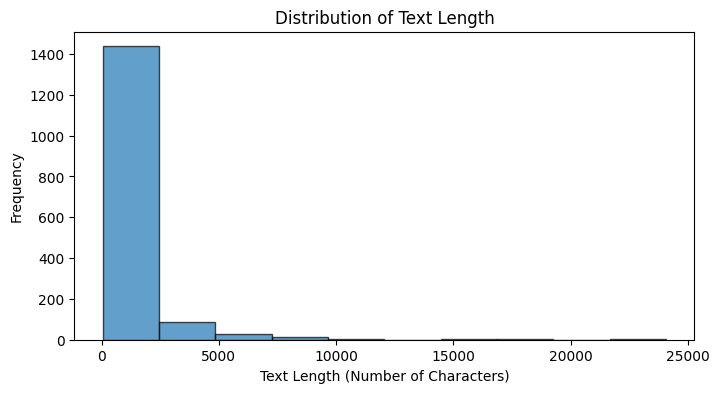

In [29]:
# Calculate the text length (number of characters) for each row
df_reddit.loc[:,'Text Length'] = df_reddit['Text'].apply(len)

# Print basic statistics
print("Basic Statistics:")
print(df_reddit['Text Length'].describe())

# Plot a histogram of text lengths
plt.figure(figsize=(8, 4))
plt.hist(df_reddit['Text Length'], bins=10, edgecolor='k', alpha=0.7)
plt.xlabel("Text Length (Number of Characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Text Length")
plt.show()

#### 2.1.7.2. <a id='toc2_1_7_2_'></a>[Word Clouds](#toc0_)

In [30]:
def generate_word_cloud(df, column):
    # Combine all text from the 'Text' column into a single string
    text = " ".join(df[column])

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(7, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud")
    plt.show()

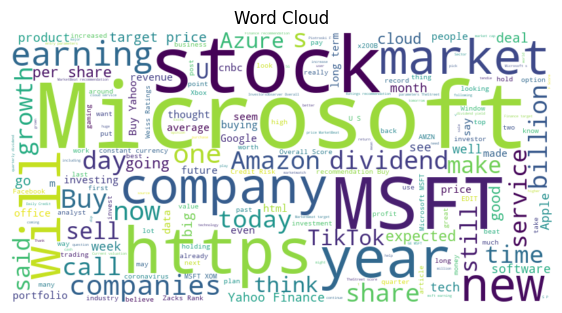

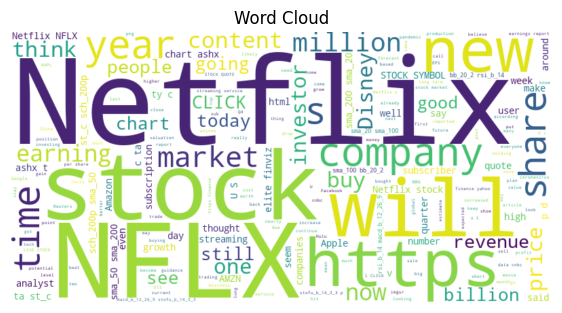

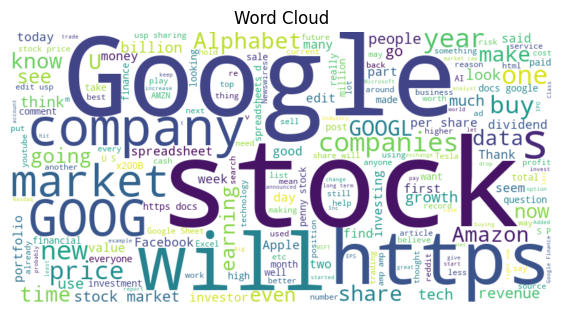

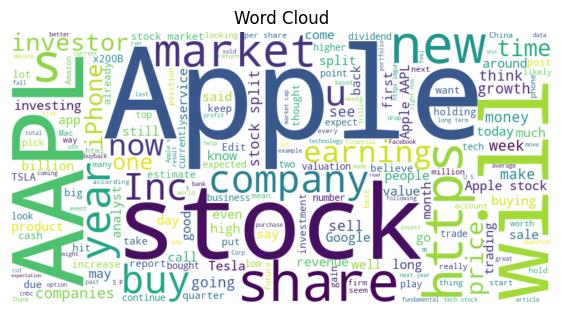

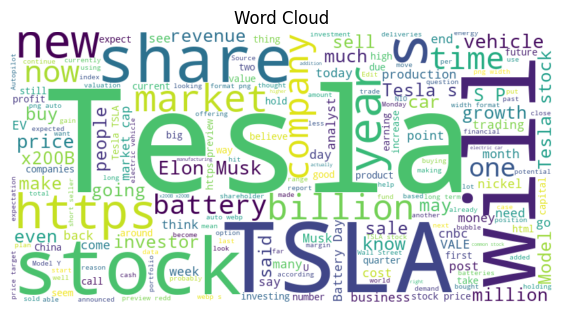

In [31]:
# Uncleaned Text
for i in df_reddit['Stock'].unique(): 
    generate_word_cloud(df_reddit[df_reddit['Stock']==i], 'Text')

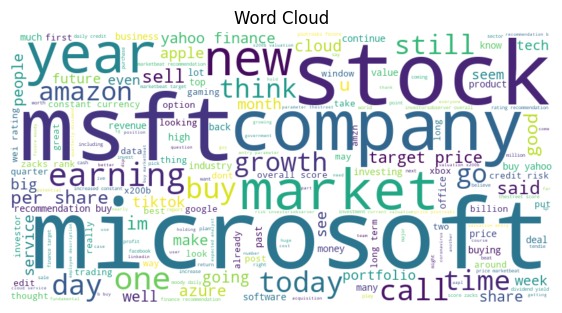

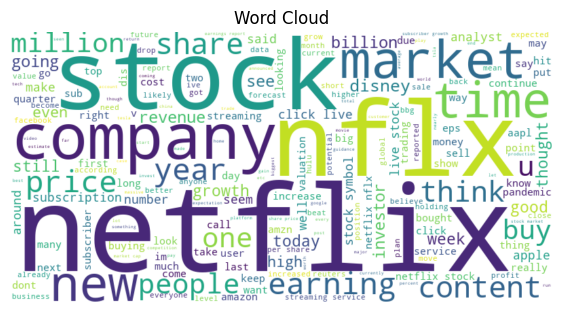

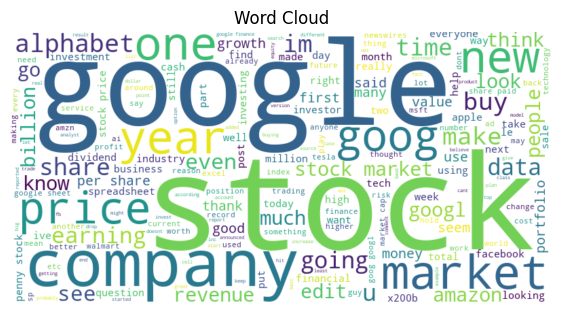

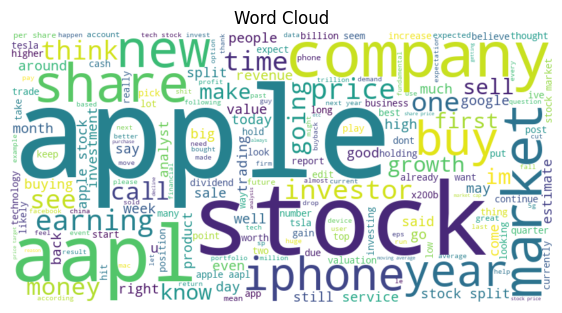

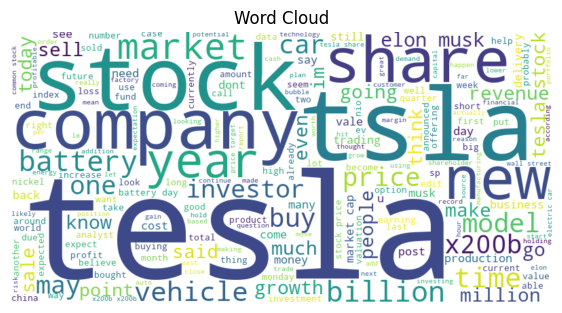

In [32]:
# Cleaned Text
for i in df_reddit['Stock'].unique(): 
    generate_word_cloud(df_reddit[df_reddit['Stock']==i], 'Cleaned_Text')

### 2.1.8. <a id='toc2_1_8_'></a>[Missing Values](#toc0_)

In [37]:
# filter the dataframe to contain values between years 2015-2020
def filter_dataframe (df):
  startdate = pd.to_datetime("2015-01-01").date()
  enddate = pd.to_datetime("2020-12-31").date()
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
  df['Date'] = df['Date'].dt.date
  df = df.loc[(df['Date'] >= startdate) & (df['Date'] <= enddate)]
  return df

# Creating a DataFrame with all unique dates from 2018-01-01 to 2020-12-31
all_dates = pd.date_range(start='2018-01-01', end='2020-12-31', freq='D')
unique_dates_df = pd.DataFrame(all_dates, columns=['Date'])
unique_dates_df = filter_dataframe(unique_dates_df)


# Get unique stock tickers from filtered_dataframe
unique_tickers = df_reddit['Stock'].unique()

# Create an empty DataFrame to store the results
missing_news_dates = pd.DataFrame(columns=['Date', 'Dtock'])

# Iterate through each stock ticker and check for missing news dates
for ticker in unique_tickers:
    # Create a temporary DataFrame for the current stock ticker
    temp_df = unique_dates_df.copy()
    temp_df['Stock'] = ticker

    # Left join with filtered_dataframe on 'date' and 'stock'
    merged_df = pd.merge(temp_df, df_reddit, on=['Date', 'Stock'], how='left')

    # Check for missing news (NaN values) 
    missing_news = merged_df[merged_df['Text'].isnull()]  

    # If there are missing news dates, append them to the result DataFrame
    if not missing_news.empty:
        missing_news_dates = pd.concat([missing_news_dates, missing_news[['Date', 'Stock']]])


print("Dates with missing reddit for each stock ticker:")
missing_news_dates['Year'] = pd.DatetimeIndex(missing_news_dates['Date']).year
missing_news_dates



# Group by 'stock' column and count the number of missing dates for each stock ticker
missing_dates_count = missing_news_dates.groupby('Stock')['Date'].count()

print("Number of missing dates for each stock ticker:")
print(missing_dates_count)




# number of missing dates for each stock per year from 2018-2020
missing_per_year_count = missing_news_dates.groupby(['Stock','Year'])['Date'].count()

print("Number of missing dates per year for each stock ticker:\n",)

print(missing_per_year_count)

Dates with missing reddit for each stock ticker:
Number of missing dates for each stock ticker:
Stock
AAPL    914
GOOG    973
MSFT    902
NFLX    871
TSLA    922
Name: Date, dtype: int64
Number of missing dates per year for each stock ticker:

Stock  Year
AAPL   2018    339
       2019    330
       2020    245
GOOG   2018    333
       2019    342
       2020    298
MSFT   2018    336
       2019    330
       2020    236
NFLX   2018    309
       2019    294
       2020    268
TSLA   2018    341
       2019    335
       2020    246
Name: Date, dtype: int64


## 2.2. <a id='toc2_2_'></a>[Twitter](#toc0_)

In [49]:
# load the data
tweet_df = pd.read_csv("Data/Tweet.csv")
company_tweet_df = pd.read_csv("Data/Company_Tweet.csv")

# Merge dataset by tweet_id to get which tweet corresponds to which ticker
tweet_company_merge = pd.merge(tweet_df,company_tweet_df,on='tweet_id',how='inner')

# Changing Google's 2 tickers to - GOOGL
tweet_company_merge.loc[tweet_company_merge['ticker_symbol'] == 'GOOGL', 'ticker_symbol'] = 'GOOG'

# Date to correct format
tweet_company_merge['post_date'] = pd.to_datetime(tweet_company_merge['post_date'], unit='s')

# Separate date and time
tweet_company_merge['date'] = tweet_company_merge['post_date'].dt.date
tweet_company_merge['time'] = tweet_company_merge['post_date'].dt.time

df_twitter = tweet_company_merge
df_twitter

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,date,time
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01,00:00:57
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01,00:01:36
2,550441732014223360,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01,00:01:50
3,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2015-01-01,00:06:47
4,550443807834402816,i_Know_First,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01,00:10:05
...,...,...,...,...,...,...,...,...,...,...
4336440,1212159838882533376,ShortingIsFun,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...,0,0,1,TSLA,2019-12-31,23:53:21
4336441,1212160015332728833,Commuternyc,2019-12-31 23:54:03,Patiently Waiting for the no twitter sitter tw...,0,0,5,TSLA,2019-12-31,23:54:03
4336442,1212160410692046849,MoriaCrypto,2019-12-31 23:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1,AAPL,2019-12-31,23:55:37
4336443,1212160410692046849,MoriaCrypto,2019-12-31 23:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1,MSFT,2019-12-31,23:55:37


There are 4M tweets in total

In [50]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   tweet_id       int64         
 1   writer         object        
 2   post_date      datetime64[ns]
 3   body           object        
 4   comment_num    int64         
 5   retweet_num    int64         
 6   like_num       int64         
 7   ticker_symbol  object        
 8   date           object        
 9   time           object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 330.8+ MB


In [51]:
df_twitter.isnull().sum()

tweet_id             0
writer           55919
post_date            0
body                 0
comment_num          0
retweet_num          0
like_num             0
ticker_symbol        0
date                 0
time                 0
dtype: int64

"writer" contains 55k missing values out of 4M tweets.

In [52]:
# Counts of tweets per stock
df_twitter['ticker_symbol'].value_counts()

ticker_symbol
AAPL    1425013
TSLA    1096868
GOOG     720138
AMZN     718715
MSFT     375711
Name: count, dtype: int64

~80k tweets for each stock.

In [53]:
# Group the data by year and count the number of posts in each year for specified stocks
pd.to_datetime(df_twitter[df_twitter['ticker_symbol']=='GOOG']['date']).dt.year.value_counts().sort_index()

date
2015    195796
2016    186084
2017    120382
2018    117158
2019    100718
Name: count, dtype: int64

~14k tweets per year for a stock

In [54]:
df_twitter.describe()

,tweet_id,post_date,comment_num,retweet_num,like_num
count,4.336445e+06,4336445,4.336445e+06,4.336445e+06,4.336445e+06
mean,8.834282e+17,2017-07-07 20:51:06.490715136,2.923863e-01,6.347647e-01,2.103625e+00
min,5.504415e+17,2015-01-01 00:00:57,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.185450e+17,2016-04-08 21:04:16,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.825934e+17,2017-07-05 13:33:54,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.054776e+18,2018-10-23 16:44:39,0.000000e+00,0.000000e+00,1.000000e+00
max,1.212160e+18,2019-12-31 23:55:53,6.310000e+02,9.990000e+02,9.990000e+02
std,1.927735e+17,NaN,1.885788e+00,6.986371e+00,1.371744e+01



Q3 for number of comments, retweets, likes is < 1. This means that most of the tweets have not been engaged into activities by the users.

In [56]:
# Cleaning the tweets data
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_tweet(text):
    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase and tokenize
    words = text.lower().split()

    # Remove stop words, lemmatize, and stem
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # words = [stemmer.stem(word) for word in words]

    # Join the words back into a clean text
    clean_text = ' '.join(words)

    return clean_text

To be implemented with saved data.

## 2.3. <a id='toc2_3_'></a>[News](#toc0_)

In [82]:
# load the data
df_analyst_ratings_processed = pd.read_csv("Data/analyst_ratings_processed.csv", encoding='UTF-8')
df_analyst_ratings_processed['stock'] = df_analyst_ratings_processed['stock'].replace(['GOOG', 'GOOGL'], 'GOOG')
df_raw_analyst_ratings = pd.read_csv("Data/raw_analyst_ratings.csv", encoding = 'UTF-8')
df_partner_headlines= pd.read_csv("Data/raw_partner_headlines.csv", encoding = 'UTF-8')


# filter the dataframe to contain values between years 2015-2020
def filter_dataframe (df):
  startdate = pd.to_datetime("2015-01-01").date()
  enddate = pd.to_datetime("2020-12-31").date()
  df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
  df['date'] = df['date'].dt.date
  df = df.loc[(df['date'] >= startdate) & (df['date'] <= enddate)]
  return df

df_analyst_ratings_processed = filter_dataframe(df_analyst_ratings_processed)
df_raw_analyst_ratings = filter_dataframe(df_raw_analyst_ratings)
df_partner_headlines = filter_dataframe(df_partner_headlines)


# filter the dataframe to contain only specific stocks
def get_statistics(df):
  categories_to_check = ['AAPL', 'GOOG','GOOGL', 'AMZN', 'MSFT','TSLA']
  filtered_df = df[df['stock'].isin(categories_to_check)]
  filtered_df['year'] = pd.DatetimeIndex(filtered_df['date']).year
  return filtered_df

df_analyst_ratings_processed = get_statistics(df_analyst_ratings_processed)
df_raw_analyst_ratings = get_statistics(df_raw_analyst_ratings)
df_partner_headlines = get_statistics(df_partner_headlines)

C:\Users\sohmt\AppData\Local\Temp\ipykernel_13392\2718190284.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['year'] = pd.DatetimeIndex(filtered_df['date']).year
C:\Users\sohmt\AppData\Local\Temp\ipykernel_13392\2718190284.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['year'] = pd.DatetimeIndex(filtered_df['date']).year
C:\Users\sohmt\AppData\Local\Temp\ipykernel_13392\2718190284.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [83]:
df_analyst_ratings_processed

,Unnamed: 0,title,date,stock,year
3668,7120.0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,2020
3669,7121.0,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,2020
3670,7122.0,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,2020
3671,7123.0,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,2020
3672,7124.0,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,2020
...,...,...,...,...,...
1250207,1263065.0,Electrek.Co Tweet: Tesla's head of Europe is out,2019-07-02,TSLA,2019
1250208,1263066.0,Tesla's Q2 Delivery Number Could Cause A Big Move,2019-07-01,TSLA,2019
1250209,1263067.0,'Tesla Electric Airplane? Elon Musk sees elect...,2019-07-01,TSLA,2019
1250210,1263068.0,"UPDATE: JMP Reiterates Outperform, $347 Target...",2019-07-01,TSLA,2019


In [84]:
df_raw_analyst_ratings.head()

,Unnamed: 0,headline,url,publisher,date,stock,year
6680,7120,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10,AAPL,2020
6681,7121,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10,AAPL,2020
6682,7122,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10,AAPL,2020
6683,7123,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10,AAPL,2020
6684,7124,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10,AAPL,2020


In [85]:
df_partner_headlines

,Unnamed: 0,headline,url,publisher,date,stock,year
4067,4130,American Pie,https://talkmarkets.com/content/american-pie?p...,TalkMarkets,2020-06-02,AAPL,2020
4068,4131,Tech Giants Dare Antitrust Deal Watchdogs,https://talkmarkets.com/content/tech-giants-da...,TalkMarkets,2020-06-02,AAPL,2020
4069,4132,MoneyGram Shares Jump 50% As Western Union Rep...,https://talkmarkets.com/content/moneygram-shar...,TalkMarkets,2020-06-02,AAPL,2020
4070,4133,All Eyes on Market Volatility,https://talkmarkets.com/content/all-eyes-on-ma...,TalkMarkets,2020-06-01,AAPL,2020
4071,4134,Warren Buffett's Berkshire Hathaway Turns Up S...,http://www.gurufocus.com/news/1152965/warren-b...,GuruFocus,2020-06-01,AAPL,2020
...,...,...,...,...,...,...,...
715202,716897,"Fundamentun, LLC Buys WisdomTree U.S. Dividend...",http://www.gurufocus.com/news/1125032/fundamen...,GuruFocus,2020-05-04,GOOGL,2020
715203,716898,"The Zacks Analyst Blog Highlights: Microsoft, ...",http://www.zacks.com/stock/news/912835/the-zac...,Zacks,2020-05-04,GOOGL,2020
715204,716899,Zacks Investment Ideas feature highlights: Goo...,http://www.zacks.com/stock/news/912746/zacks-i...,Zacks,2020-05-04,GOOGL,2020
715205,716900,BT Investment Management Ltd Buys Atmos Energy...,http://www.gurufocus.com/news/1124838/bt-inves...,GuruFocus,2020-05-04,GOOGL,2020


Number of rows in the df_analytics: 5523

Number of rows in the df_analyst_rating: 50

Number of rows in the df_partner_headlines: 212

In [86]:
df_news = df_analyst_ratings_processed

In [87]:
# drop the specific column
df_news.drop(columns='Unnamed: 0', inplace=True)

In [88]:
df_news.info()
df_news['date'] = pd.to_datetime(df_news['date'])

<class 'pandas.core.frame.DataFrame'>
Index: 5523 entries, 3668 to 1250211
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5523 non-null   object
 1   date    5523 non-null   object
 2   stock   5523 non-null   object
 3   year    5523 non-null   int32 
dtypes: int32(1), object(3)
memory usage: 194.2+ KB


In [89]:
df_news.describe()

,date,year
count,5523,5523.000000
mean,2019-11-24 20:43:24.671374336,2019.475647
min,2018-07-25 00:00:00,2018.000000
25%,2019-08-08 00:00:00,2019.000000
50%,2020-01-21 00:00:00,2020.000000
75%,2020-04-13 00:00:00,2020.000000
max,2020-06-10 00:00:00,2020.000000
std,NaN,0.611296


In [90]:
df_news['stock'].value_counts()

stock
GOOG    2794
TSLA    1930
AAPL     469
AMZN     330
Name: count, dtype: int64

~400 posts for AAPL and AMZN with ~2000 posts for GOOG, TSLA.

This is because the start date is July2018 and the end date is June2020.

In [91]:
# Group the data by year and count the number of posts in each year for specified stocks
print(pd.to_datetime(df_news[df_news['stock']=='GOOG']['date']).dt.year.value_counts().sort_index())

print(pd.to_datetime(df_news[df_news['stock']=='TSLA']['date']).dt.year.value_counts().sort_index())

print(pd.to_datetime(df_news[df_news['stock']=='AAPL']['date']).dt.year.value_counts().sort_index())

print(pd.to_datetime(df_news[df_news['stock']=='AMZN']['date']).dt.year.value_counts().sort_index())

date
2018     343
2019    1477
2020     974
Name: count, dtype: int64
date
2019     733
2020    1197
Name: count, dtype: int64
date
2020    469
Name: count, dtype: int64
date
2020    330
Name: count, dtype: int64


The posts are inconsistently spread across years. This possesses a problem.

In [96]:
df_news.to_csv('Data/News.csv')

# 3. <a id='toc3_'></a>[VADER Sentiment Scores](#toc0_)

In [105]:
def perform_sentiment_analysis(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Perform sentiment analysis for each 'text' in the DataFrame
    # sentiment_scores = df['Text'].apply(lambda x: sia.polarity_scores(x))
    sentiment_scores = df['Cleaned_Text'].apply(lambda x: sia.polarity_scores(x))

    # Map the sentiment scores to sentiment labels
    sentiment_labels = sentiment_scores.apply(lambda x: 'Positive' if x['compound'] > 0 else 'Negative' if x['compound'] < 0 else 'Neutral')

    # Add sentiment labels to the DataFrame
    df['VADER_sentiment'] = sentiment_labels

    return df

## 3.1. <a id='toc3_1_'></a>[Twitter](#toc0_)

In [ ]:
# Same as in TweetData

## 3.2. <a id='toc3_2_'></a>[Reddit](#toc0_)

In [81]:
# Load the data
df_reddit = pd.read_csv("Data\RedditPosts_Cleaned.csv")

# function call
df_reddit = perform_sentiment_analysis(df_reddit)

df_reddit

,Unnamed: 0,Date,Text,Stock,Cleaned_Text,VADER_sentiment
0,0,2015-01-11,What is the ONE stock you are most excited abo...,MSFT,one stock excited right timeline one stock jud...,Positive
1,1,2015-01-12,NFLX: Buy/Hold/Sell thoughts? domestic growth ...,NFLX,nflx buyholdsell thought domestic growth defin...,Positive
2,2,2015-01-15,Anyone have the marketing/press documents ISIS...,GOOG,anyone marketingpress document isi islamic sta...,Positive
3,3,2015-01-15,http://www.gurufocus.com/stock/AAPL I am new t...,AAPL,httpwwwgurufocuscomstockaapl new investing sto...,Positive
4,4,2015-01-16,"Tesla will not be profitable, under generally ...",TSLA,tesla profitable generally accepted accounting...,Positive
...,...,...,...,...,...,...
1576,1576,2020-12-30,"Tesla Will Hit 500,000 Deliveries for 2020, An...",TSLA,tesla hit 500000 delivery 2020 analyst predict...,Positive
1577,1577,2020-12-31,"What do you think, could tesla stock collapse ...",GOOG,think could tesla stock collapse bring new mar...,Negative
1578,1578,2020-12-31,Tesla Short Sellers Lost $38 Billion in 2020 a...,TSLA,tesla short seller lost 38 billion 2020 stock ...,Positive
1579,1579,2020-12-31,AAPL is the 2021 Play Missed out on the TSLA r...,AAPL,aapl 2021 play missed tsla run 2020 aww ’ cute...,Positive


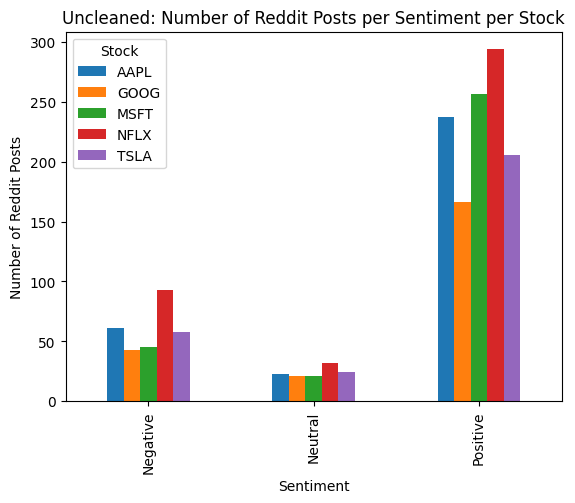

In [103]:
# Group by 'VADER_sentiment' and 'Stock' and count the number of Reddit posts
reddit_counts = df_reddit.groupby(['VADER_sentiment', 'Stock']).size().unstack(fill_value=0)

# Create the side-by-side bar graph
ax = reddit_counts.plot(kind='bar', stacked=False)
plt.xlabel('Sentiment')
plt.ylabel('Number of Reddit Posts')
plt.title('Uncleaned: Number of Reddit Posts per Sentiment per Stock')
plt.legend(title='Stock', loc='upper left')
plt.show()

Using Vader Scores, we can see that most fo the posts have **Positive** sentiments.

This accounts for **Class Imbalance.**

In [106]:
# function call for cleaned text
df_reddit = perform_sentiment_analysis(df_reddit)

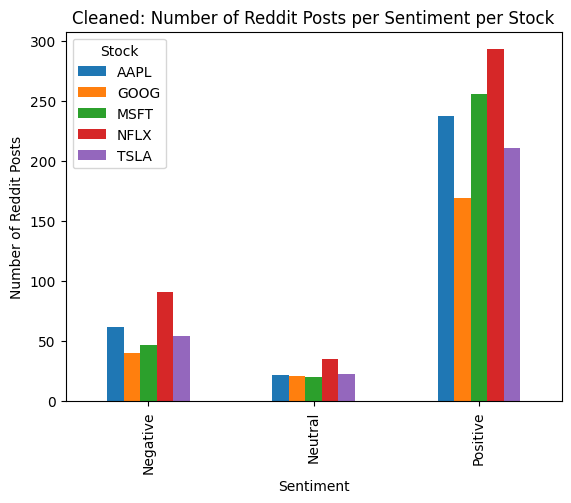

In [107]:
# Group by 'VADER_sentiment' and 'Stock' and count the number of Reddit posts
reddit_counts = df_reddit.groupby(['VADER_sentiment', 'Stock']).size().unstack(fill_value=0)

# Create the side-by-side bar graph
ax = reddit_counts.plot(kind='bar', stacked=False)
plt.xlabel('Sentiment')
plt.ylabel('Number of Reddit Posts')
plt.title('Cleaned: Number of Reddit Posts per Sentiment per Stock')
plt.legend(title='Stock', loc='upper left')
plt.show()

## 3.3. <a id='toc3_3_'></a>[News](#toc0_)

In [99]:
# Load the data
df_news = pd.read_csv('Data/News.csv')

# drop the specific column
df_news.drop(columns='Unnamed: 0', inplace=True)

# Convert to suitable datatype
df_news.loc[:, 'date'] = pd.to_datetime(df_news['date']).dt.date

df_news.columns = ['Text', 'Date', 'Stock', 'Year']

# function call
df_news = perform_sentiment_analysis(df_news)

df_news

,Text,Date,Stock,Year,VADER_sentiment
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,2020,Positive
1,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,2020,Neutral
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,2020,Positive
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,2020,Neutral
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,2020,Positive
...,...,...,...,...,...
5518,Electrek.Co Tweet: Tesla's head of Europe is out,2019-07-02,TSLA,2019,Neutral
5519,Tesla's Q2 Delivery Number Could Cause A Big Move,2019-07-01,TSLA,2019,Positive
5520,'Tesla Electric Airplane? Elon Musk sees elect...,2019-07-01,TSLA,2019,Neutral
5521,"UPDATE: JMP Reiterates Outperform, $347 Target...",2019-07-01,TSLA,2019,Negative


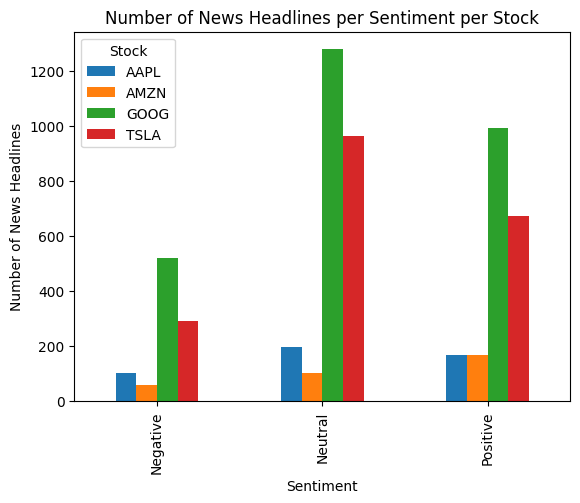

In [101]:
# Group by 'VADER_sentiment' and 'Stock' and count the number of News Headlines
news_counts = df_news.groupby(['VADER_sentiment', 'Stock']).size().unstack(fill_value=0)

# Create the side-by-side bar graph
ax = news_counts.plot(kind='bar', stacked=False)
plt.xlabel('Sentiment')
plt.ylabel('Number of News Headlines')
plt.title('Number of News Headlines per Sentiment per Stock')
plt.legend(title='Stock', loc='upper left')
plt.show()

Using Vader Scores, we can see that most fo the news have **Neutral** sentiments and some significant **Positive** sentiments.

This accounts for **Class Imbalance.**, specially for **Negative** sentiments.

# 4. <a id='toc4_'></a>[Combine Data with Stock Prices](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Load the data](#toc0_)

In [32]:
# Override pandas datareader with yfinance
yf.pdr_override()

# Define the list of stock symbols
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT']

# Define the start and end dates for data retrieval
startdate = dt.datetime(2015, 1, 1)
enddate = dt.datetime(2020, 12, 31)

# Retrieve historical stock price data for the specified symbols and date range
df = yf.download(y_symbols, start=startdate, end=enddate)

# Stack the multi-level index to create a single-level index
df = df.stack(level=1)

# Reset the index to make 'Date' a regular column
df = df.reset_index()

# Rename the columns to match the desired structure
df.columns = ['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

[*********************100%%**********************]  5 of 5 completed


In [33]:
df_stocks = df
df_stocks

,Date,Stock,Adj Close,Close,High,Low,Open,Volume
0,2015-01-02,AAPL,24.498684,27.332500,27.860001,26.837500,27.847500,212818400
1,2015-01-02,AMZN,15.426000,15.426000,15.737500,15.348000,15.629000,55664000
2,2015-01-02,GOOG,26.168653,26.168653,26.490770,26.133251,26.378078,28951268
3,2015-01-02,MSFT,40.534843,46.759998,47.419998,46.540001,46.660000,27913900
4,2015-01-02,TSLA,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
...,...,...,...,...,...,...,...,...
7545,2020-12-30,AAPL,131.572449,133.720001,135.990005,133.399994,135.580002,96452100
7546,2020-12-30,AMZN,164.292496,164.292496,167.104996,164.123505,167.050003,64186000
7547,2020-12-30,GOOG,86.975998,86.975998,88.254753,86.279999,88.100502,26122000
7548,2020-12-30,MSFT,216.320404,221.679993,225.630005,221.470001,225.229996,20272300


## 4.2. <a id='toc4_2_'></a>[Merge with Reddit data](#toc0_)

In [34]:
df_reddit = df_reddit[['Date', 'Stock', 'Cleaned_Text']]
df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])

In [35]:
# Merge the stock and sentiment data based on 'Date' and 'Stock'
merged_data = pd.merge(df_stocks, df_reddit, on=['Date', 'Stock'], how='left')
merged_data

,Date,Stock,Adj Close,Close,High,Low,Open,Volume,Cleaned_Text
0,2015-01-02,AAPL,24.498684,27.332500,27.860001,26.837500,27.847500,212818400,NaN
1,2015-01-02,AMZN,15.426000,15.426000,15.737500,15.348000,15.629000,55664000,NaN
2,2015-01-02,GOOG,26.168653,26.168653,26.490770,26.133251,26.378078,28951268,NaN
3,2015-01-02,MSFT,40.534843,46.759998,47.419998,46.540001,46.660000,27913900,NaN
4,2015-01-02,TSLA,14.620667,14.620667,14.883333,14.217333,14.858000,71466000,NaN
...,...,...,...,...,...,...,...,...,...
7769,2020-12-30,AAPL,131.572449,133.720001,135.990005,133.399994,135.580002,96452100,NaN
7770,2020-12-30,AMZN,164.292496,164.292496,167.104996,164.123505,167.050003,64186000,NaN
7771,2020-12-30,GOOG,86.975998,86.975998,88.254753,86.279999,88.100502,26122000,drone stock hey fellow investor ’ know heard n...
7772,2020-12-30,MSFT,216.320404,221.679993,225.630005,221.470001,225.229996,20272300,NaN


In [36]:
merged_data.isnull().sum()

Date               0
Stock              0
Adj Close          0
Close              0
High               0
Low                0
Open               0
Volume             0
Cleaned_Text    6849
dtype: int64

Obviously 6851 rows have missing reddit data

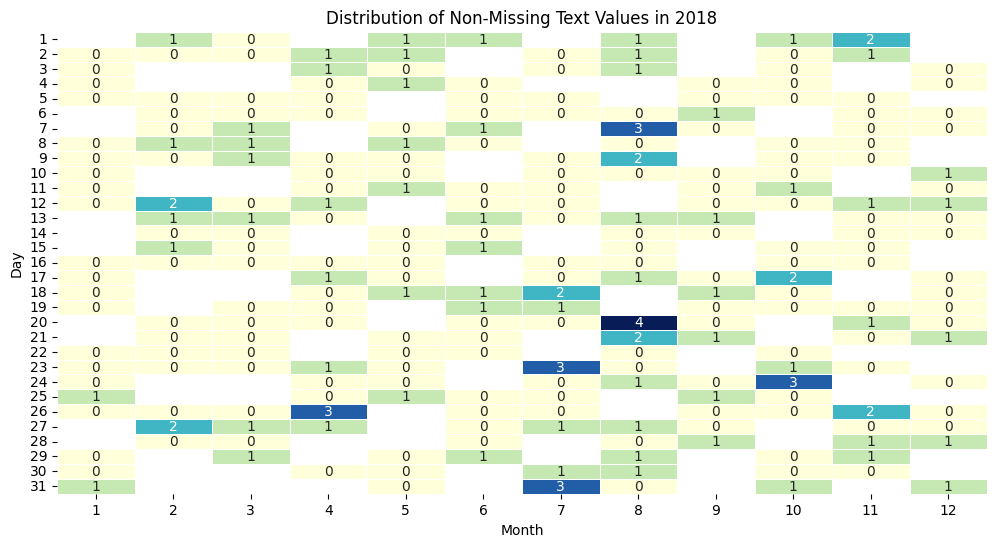

In [37]:
# Filter the data for the year 2018
df_2018 = merged_data[merged_data['Date'].dt.year == 2018]

# Pivot the data to create a table where each day is a row and each column represents the presence of text
pivot_table = df_2018.pivot_table(index=df_2018['Date'].dt.day, columns=df_2018['Date'].dt.month, values='Cleaned_Text', aggfunc='count')

# Create a heatmap to visualize the distribution of non-missing values
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=.5, annot=True, fmt='g', cbar=False)

# Customize the plot labels and title
plt.xlabel("Month")
plt.ylabel("Day")
plt.title("Distribution of Non-Missing Text Values in 2018")

# Show the plot
plt.show()

Here, we can see that the values are spread across the days across the year.

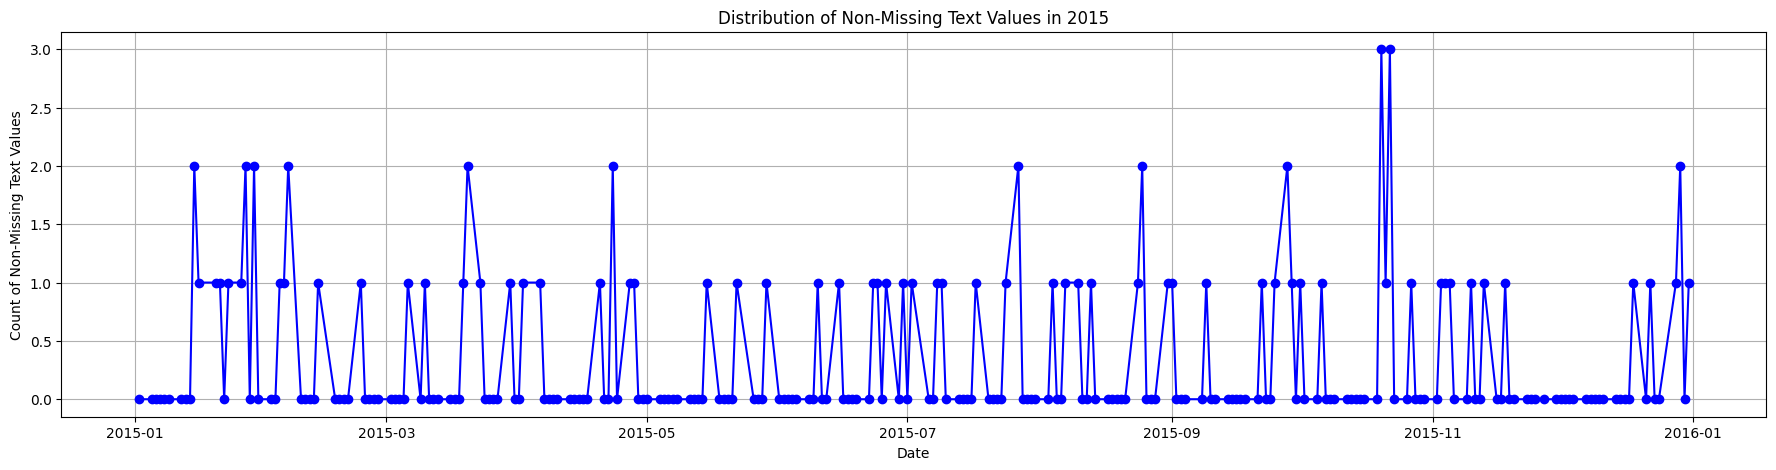

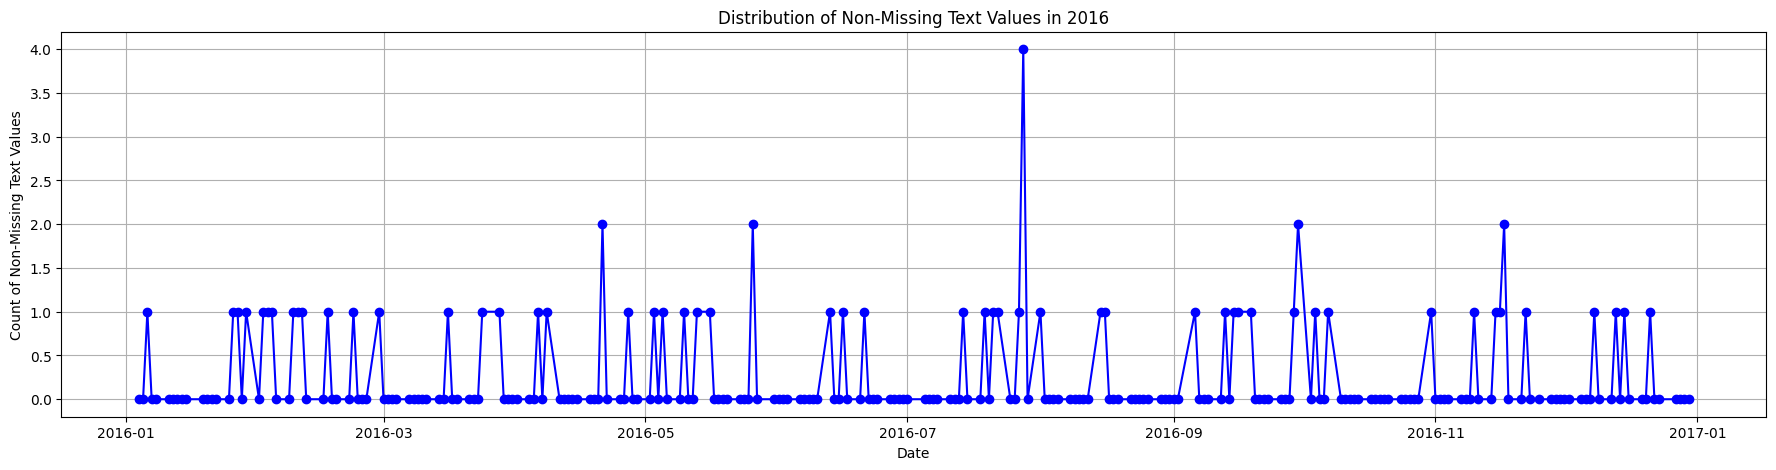

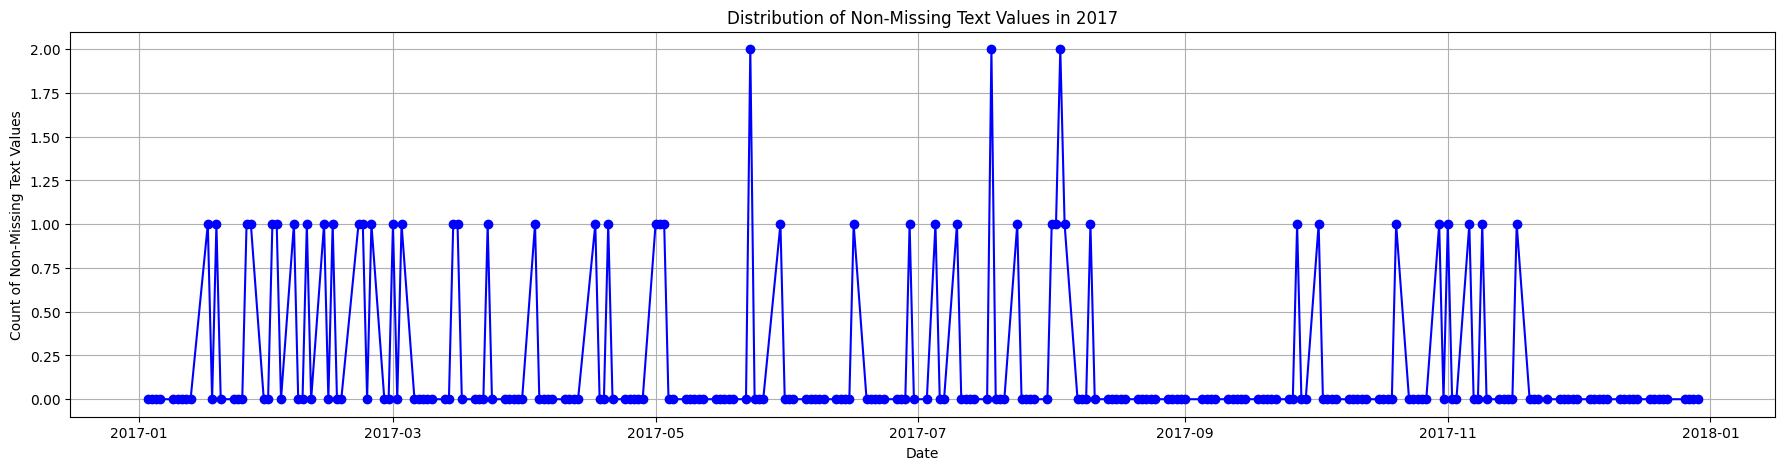

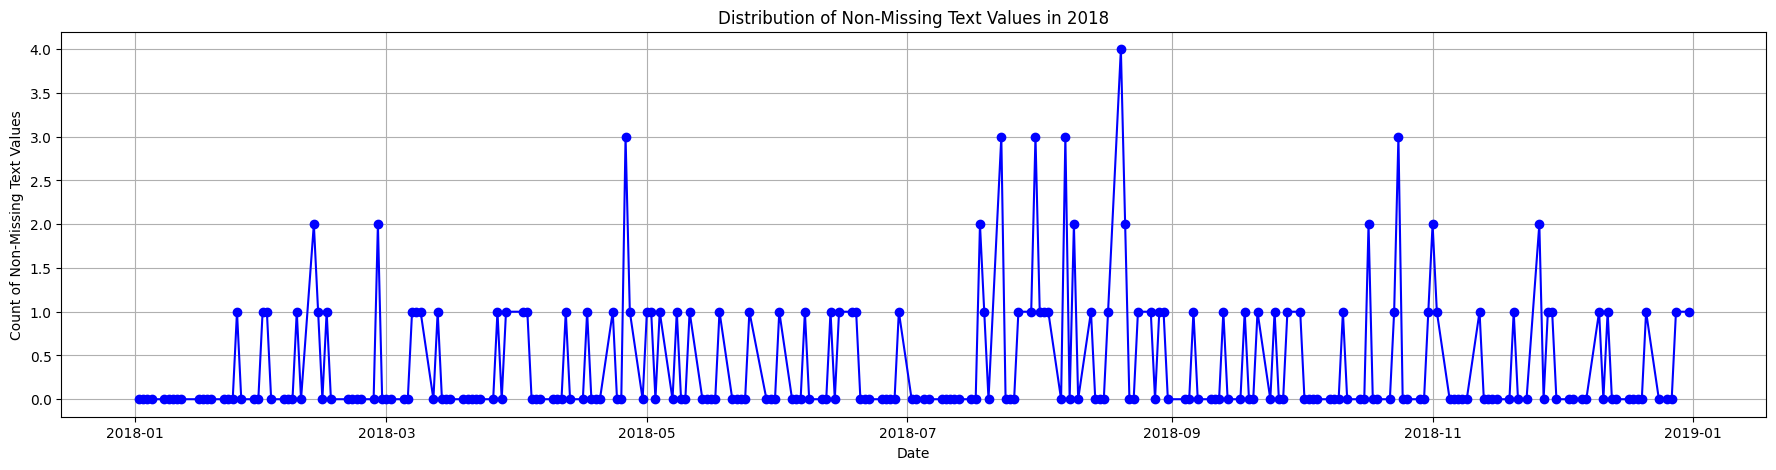

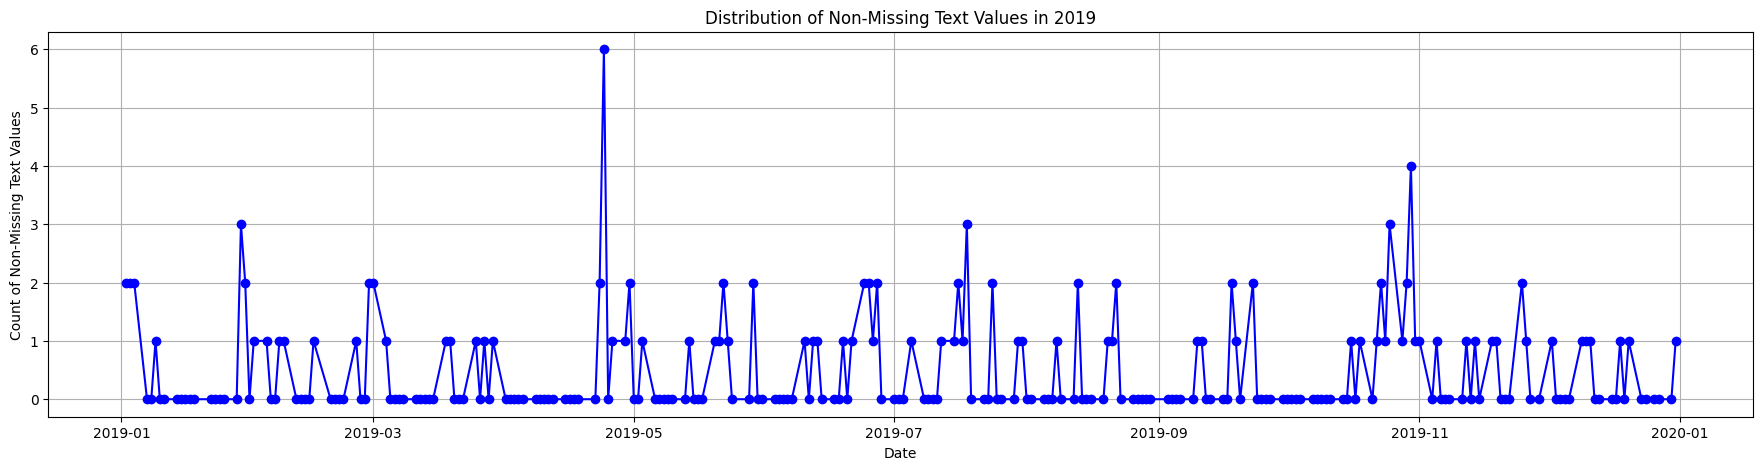

In [40]:
for i in range(2015, 2020):    
    # Filter the data for the year 2018
    df = merged_data[merged_data['Date'].dt.year == i]

    # Group the data by day and count non-missing text values
    daily_counts = df.groupby(df['Date'].dt.date)['Cleaned_Text'].count()

    # Create a line plot to visualize the trend
    plt.figure(figsize=(22, 5))
    daily_counts.plot(kind='line', marker='o', linestyle='-', color='b')

    # Customize the plot labels and title
    plt.xlabel("Date")
    plt.ylabel("Count of Non-Missing Text Values")
    title_text= "Distribution of Non-Missing Text Values in " + str(i)
    plt.title(title_text)

    # Show the plot
    plt.grid()
    plt.show()

This seconds our argument for the spread of values.

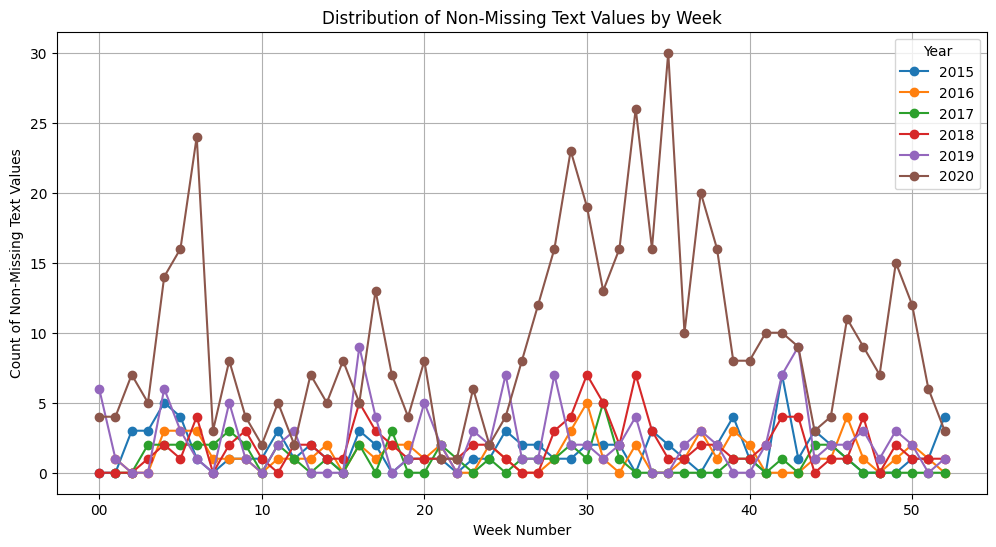

In [29]:
# Extract the year and week number from the 'Date' column
merged_data['Year'] = merged_data['Date'].dt.year
merged_data['WeekNumber'] = merged_data['Date'].dt.strftime('%U')

# Group the data by 'WeekNumber' and 'Year' and count non-missing text values
weekly_counts = merged_data.groupby(['WeekNumber', 'Year'])['Cleaned_Text'].count().unstack()

plt.figure(figsize=(12, 6))

# Create a line plot to visualize the distribution for each year
for year in weekly_counts.columns:
    weekly_counts[year].plot(kind='line', marker='o', linestyle='-', label=str(year))

# Customize the plot labels and title
plt.xlabel("Week Number")
plt.ylabel("Count of Non-Missing Text Values")
plt.title("Distribution of Non-Missing Text Values by Week")
plt.legend(title="Year", loc="upper right")

# Show the plot
plt.grid()
plt.show()

Here we can see that year 2020 has significantly more data than other years.

C:\Users\sohmt\AppData\Local\Temp\ipykernel_13392\1476994937.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'WeekNumber'] = df['Date'].dt.strftime('%U')


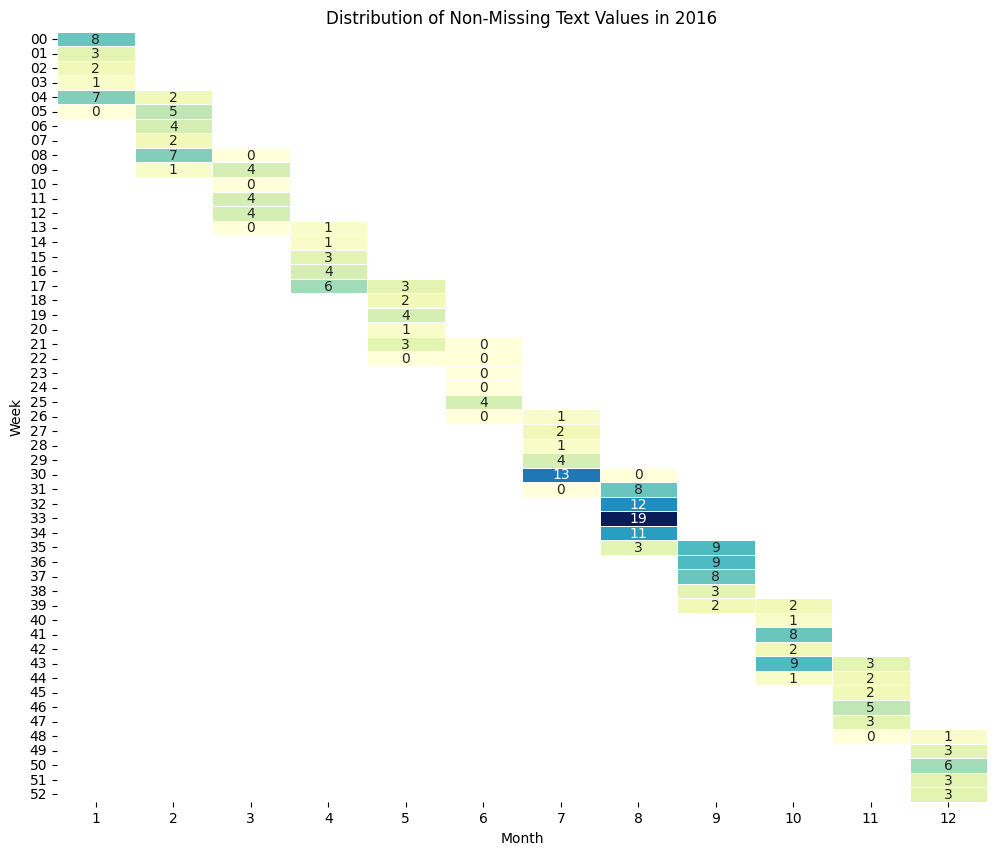

In [48]:
# Create a range of years (2015 to 2019)
years = range(2016, 2017)

for year in years:
    # Filter the data for the current year
    df = merged_data[merged_data['Date'].dt.year == year]
    
    df = merged_data[merged_data['Stock'] == 'AAPL']

    # Extract the week number from the 'Date' column
    df.loc[:, 'WeekNumber'] = df['Date'].dt.strftime('%U')

    # Pivot the data to create a table where each week is a row and each column represents the presence of text
    pivot_table = df.pivot_table(index=df['WeekNumber'], columns=df['Date'].dt.month, values='Cleaned_Text', aggfunc='count')

    # Create a heatmap to visualize the distribution of non-missing values
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=.5, annot=True, fmt='g', cbar=False)

    # Customize the plot labels and title
    plt.xlabel("Month")
    plt.ylabel("Week")
    plt.title(f"Distribution of Non-Missing Text Values in {year}")

    # Show the plot for the current year
    plt.show()

Almost every week across the year has values for APPL stock.

## 4.3. <a id='toc4_3_'></a>[Merge with Twitter data](#toc0_)

In [ ]:
df_reddit = df_reddit[['Date', 'Stock', 'Cleaned_Text']]
df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])

In [ ]:
# Merge the stock and sentiment data based on 'Date' and 'Stock'
merged_data = pd.merge(df_stocks, df_reddit, on=['Date', 'Stock'], how='left')